# 1. Import and Install Dependencies

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import pandas as pd

# 2. Keypoints using MP Holistic

importiamo il modello Holistic di MediaPipe

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils # Drawing utilities
mp_drawing_styles = mp.solutions.drawing_styles

funzione di riconoscimento: convertiamo prima l'immagine dal canale BGR (output di OpenCV feed) a quello RGB, necessario per MediaPipe;
alla fine riconvertiamo in BGR

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction with the Holistic model
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

ora visualizziamo i landmark graficamente, in maniera standard; li renderizziamo -> saranno visibili a schermo

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

#le X_CONNECTIONS sono mappe che restituiscono i legami fra i vari landmark

formattiamo, personalizziamo i landmark in maniera grafica

In [4]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=1, circle_radius=1)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=1, circle_radius=1)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=1, circle_radius=1)
                             ) 

# 3. Extract Keypoint Function

restituisce il numero dei landmark usati per la parte del corpo specificata

Lavoriamo su ciascun landkmark: 

- creiamo degli array dove memorizzare le sue coordinate (dei landmark)

- Useremo degli array di zero quando una certa parte del corpo non è riconosciuta/presente, per non fare andare in errore il sistema.

Facciamo la stessa cosa, ma tutto su una sola linea.

**N.B.** usiamo *flatten()* perchè vogliamo un solo array, unidimensionale, perchè ci servirà questo formato per la LSTM; infatti, senza flatten() avremo una matrice, un array bidimensionale (ciascun landmark avrà *x* valori associati)

come abbiamo detto prima, creiamo un array vuoto (di zeri), per gestire l'errore nel caso in cui una parte del corpo non è riconosciuta.

qui facciamo quello fatto sopra, ma in maniera pù organizzata, in una funzione apposita:

In [5]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

nello specifico:

res.x, res.y, res.z sono i singoli valori delle coord. per ciascun landmark, che verranno inseriti in un array più grande, ciclando per ogni landmark:

- se non esistono coordinate per i landmark, quindi quella parte del corpo non è riconosciuta, viene creato un array vuoto

### abbiamo estratto i **keypoints** per il frame di interesse, che saranno utili per il riconoscimento dei gesti/segni

# 4. Setup Folders

quali sono i gesti contenuti nel dataset?

In [6]:
labels_file = pd.read_csv(r'D:\TMS\dataset\jester\labels\labels.csv') #TODO rel path

gestures = labels_file['labels'].tolist() #metto in una lista tutte le labels del dataset

memorizzo la lista di tutti i video disponibili

In [7]:
DATADIR = r'D:\TMS\dataset\jester\20bn-jester-v1'

list_video = sorted(os.listdir(DATADIR), key=len) #li voglio ordinati così come compaiono nell'explorer dei file

creo fold in cui salvare keypoints, per ogni video

In [ ]:
for vid in list_video: #per ogni video
        try: 
            os.makedirs(os.path.join(DATADIR, str(vid), "keypoints"))
        except:
            pass #se esistono già, skippa la creazione

creo ora folds dei gesti, dove salvaremo ogni video in cui la stessa è performata

In [ ]:
for label in gestures: #per ogni label (per ogni gesto)
    try:
        os.makedirs(os.path.join(DATADIR, label))
    except:
        pass #se esistono già, skippa la creazione

ora dovremmo spostare in queste cartelle i relativi video

# 5. Collect Keypoint Values from the dataset for Training and Testing

❗❗ Estrarremo i keypoints dai frame di ciascun video presente nel **dataset** *Jester*

Struttura del dataset Jester:

- **VIDEO:** 148092
    - **FRAME x video:** circa 30
        - *FPS:* 12, un frame ogni 12 s
        - *altezza:* 100px

Il dataset, contenente **148092** video, è inoltre già splittato negli insiemi di **Training, Test e Validation:**

- **TRAINING videos:** 118562 
- **TEST videos:** 14743 
- **VALIDATION videos:** 14787 

Il dataset conterrà **27** labels (classi) di gesti diversi

otteniamo i video per il **training** del modello:

In [8]:
train_file = pd.read_csv(r'D:\TMS\dataset\jester\labels\train.csv', delimiter=";") #TODO path relativo

train_list = train_file['key'].tolist() #lista degli indici dei video attualmente estratti
train_file

key                      value
0        34870           Drumming Fingers
1        56557  Sliding Two Fingers Right
2       129112   Sliding Two Fingers Down
3        63861     Pulling Two Fingers In
4       131717     Sliding Two Fingers Up
...        ...                        ...
118557   75507               Swiping Down
118558   48433   Sliding Two Fingers Left
118559  146421  Sliding Two Fingers Right
118560   49514                   Thumb Up
118561    4502     Sliding Two Fingers Up

[118562 rows x 2 columns]

otteniamo ora i video per il **testing** del modello:

In [9]:
test_file = pd.read_csv(r'D:\TMS\dataset\jester\labels\test-answers.csv', delimiter=";") #TODO path relativo

test_list = test_file['key'].tolist() #lista degli indici dei video attualmente estratti
test_file = test_file.loc[:, ~test_file.columns.str.contains('^Unnamed')]  #cancello colonne non necessarie
test_file

key                          value
0      115190  Turning Hand Counterclockwise
1       49340         Turning Hand Clockwise
2      118693                   Shaking Hand
3      141855                Pulling Hand In
4      138995                     Thumb Down
...       ...                            ...
14738   82713                     Swiping Up
14739  129898   Zooming Out With Two Fingers
14740   86265                  Swiping Right
14741  140844     Zooming Out With Full Hand
14742   58593                   Shaking Hand

[14743 rows x 2 columns]

#### **N.B.** Vediamo ora tre modi diversi per estrarre i frame, a seconda della *fonte* (camera, dataset, ...)

- ##### **qui** ⬇️ leggiamo semplicemente i frame dal dataset, *già* estratti dai video

*prima però bisogna considerare che non ho estratto dall'archivio .tar tutti i video ...*

- vediamo prima il **training set**

In [24]:
count = 0
my_train_list = [] #lista che contiene i miei video di training, attualmente disponibili

#mostra tutti gli indici dei video attualmente estratti dall'archivio tar, convertiti in integers
list_video_int = list(map(int, list_video))

for vid in list_video_int:
    for train_vid in train_list:
        if vid == train_vid:
            count += 1     
            my_train_list.append(vid)

attualmente, abbiamo **30228** video di training su 37793 totali (80% circa)

In [25]:
np.save("mytrainlist", my_train_list)

In [10]:
my_train_list = np.load("mytrainlist.npy").tolist()
len(my_train_list)

30228

In [11]:
my_train_file = train_file.query('key in @my_train_list') #sottoinsieme di train_file, che contiene solo i video di training attualm. disponibili
train_list2 = sorted(my_train_file['key'].tolist())  #lista degli indici dei video di training attualmente disponibili

my_train_file

key                         value
2       129112      Sliding Two Fingers Down
4       131717        Sliding Two Fingers Up
5        23595  Zooming Out With Two Fingers
6        93002               Pulling Hand In
7       136859                      Thumb Up
...        ...                           ...
118540  106904            Doing other things
118541   96650      Sliding Two Fingers Down
118544   43396                    Thumb Down
118550  132112                    Swiping Up
118556   99358                     Stop Sign

[30228 rows x 2 columns]

controllo effettivamente se le liste sono uguali: in tal caso tengo conto solamente di una delle due

In [12]:
if(set(my_train_list) == set(train_list2)):
    print("Lists are equal")
else:
    print("Lists are not equal")

Lists are equal


- facciamo lo stesso per il **test set**

In [19]:
count = 0
my_test_list = [] #lista che contiene i miei video di test, attualmente disponibili

#mostra tutti gli indici dei video attualmente estratti dall'archivio tar, convertiti in integers
list_video_int = list(map(int, list_video))

for vid in list_video_int:
    for test_vid in test_list:
        if vid == test_vid:
            count += 1     
            my_test_list.append(vid)

attualmente abbiamo **3763** video di test su 37793 totali (10% circa)

In [17]:
np.save("mytestlist", my_test_list)

In [12]:
my_test_list = np.load("mytestlist.npy").tolist()
len(my_test_list)

3763

In [13]:
my_test_file = test_file.query('key in @my_test_list') #sottoinsieme di test_file, che contiene solo i video di testing attualm. disponibili
my_test_list2 = sorted(my_test_file['key'].tolist())  #lista degli indici dei video di testing attualmente disponibili

my_test_file

key                          value
0      115190  Turning Hand Counterclockwise
4      138995                     Thumb Down
6       60037       Pushing Two Fingers Away
8      106678                     Swiping Up
9      139247               Drumming Fingers
...       ...                            ...
14724   17730               Drumming Fingers
14727   78775         Pulling Two Fingers In
14730   35240                     Swiping Up
14731  131876                     Thumb Down
14736   71621               Drumming Fingers

[3763 rows x 2 columns]

In [15]:
if(set(my_test_list) == set(my_test_list2)):
    print("Lists are equal")
else:
    print("Lists are not equal")

Lists are equal


##### ----------------------------------------------------------------------------------------------------------------------------------------------------

#### **TODO LIST**

- ⬜️ devo ottenere tutte le label associate alla lista di indici/key ottenuta precedentemente
- ✅ estrarre i keypoints da ciascun frame di ogni video (solo 5k per ora)
    - controllare che siano tutti
- ✅ dove salvare poi i keypoints? creare fold all'interno della fold di ogni video in cui memorizzare i keypoints in forma di array
- ⬜️ resta poi da organizzare i video in base alle azioni eseguite al loro interno

##### ----------------------------------------------------------------------------------------------------------------------------------------------------

- ### accedo ai frame di ogni video di TRAINING e ne estraggo i keypoints

In [ ]:
DATADIR = r'D:\TMS\dataset\jester\20bn-jester-v1'

actual_train_video = []
actual_video = []

with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:

    for vid in my_train_list:  # itero su tutti i video ...

        # create path (...\20bn-jester-v1\000xx)
        path = os.path.join(DATADIR, str(vid))
        print("\nPercorso video:", path)

        # restituisce tutti gli elementi nel path indicato, nel nostro caso tutti i frame per il video specificato con il suo path
        frames_4_video = os.listdir(path)
        
        num_frames = len(frames_4_video) - 1 #togliamo 1 perchè non consideriamo la fold dei keypoints
        print("Numero frame per questo video:", num_frames)

        all_frames = []

        keypoints_path = os.path.join(path, 'keypoints')

        num_keypoints = len(os.listdir(keypoints_path)) #indica quanti keypoints sono stati estratti            
        
        # esegui se la fold dei keypoints è vuota ed i keypoints non sono ancora stati estratti da ogni frame 
        if not os.listdir(keypoints_path) and num_keypoints != num_frames:
            break
            
            # iterate over each image (00001, 00002, ...)S
            for img in frames_4_video:            
                        
                if not img == 'keypoints': #non considero la cartella dove salvo i keypoints (TODO potrei farlo prima, escludendo la cartella)
                    
                    img_num = img[0:5] #prendo i primi N char, per non avere l'estensione nel nome quando salvo dopo

                    img_path = os.path.join(path, img)
                    img_array = cv2.imread(img_path)  # convert to array
                    print(img_path)                    
                    all_frames.append(img)

                    # estraggo e memorizzo i keypoints
                    image, results = mediapipe_detection(img_array, holistic)
                    draw_styled_landmarks(image, results)
                    #print(results)
                    #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))                    
                    keypoints = extract_keypoints(results)

                    # salvo i keypoints su disco
                    npy_path = os.path.join(DATADIR, str(vid), "keypoints", img_num)
                    np.save(npy_path, keypoints)
            
        else:
            print("N.B. keypoints già estratti per questo video")
            actual_train_video.append(vid)
            actual_video.append(vid)

opero altra suddivisione (attualmente **5k** circa video disponibili) per **TRAINING SET** ottenendo il file su cui **classificare**

In [14]:
my_train_file2 = my_train_file.query('key in @actual_train_video') #contiene indice e label dell'azione associata a quel video

my_train_file2.sort_values(["key"], axis=0, ascending=[True], inplace=True) #ordino gli elem in modo crescente in base al valore dell'idx del video 

np.save("mytrainfile2", my_train_file2)

my_train_file2 #questo è il file su cui devo lavorare come training set


KeyboardInterrupt



abbiamo dunque **1124** video di training su cui addestrare il modello

controllo le coordinate dei keypoints estratti per un frame a caso

In [43]:
np.load(r"D:\TMS\dataset\jester\20bn-jester-v1\5430\keypoints\00015.npy")

array([ 0.51776236,  0.4528217 , -0.93003947, ...,  0.35263199,
        0.48780304, -0.07810371])

- ### accedo ai frame di ogni video di TEST e ne estraggo i keypoints

In [ ]:
DATADIR = r'D:\TMS\dataset\jester\20bn-jester-v1'

actual_test_video = []

with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:

    for vid in my_test_list:  # itero su tutti i video ...

        # create path (...\20bn-jester-v1\000xx)
        path = os.path.join(DATADIR, str(vid))
        print("\nPercorso video:", path)

        # restituisce tutti gli elementi nel path indicato, nel nostro caso tutti i frame per il video specificato con il suo path
        frames_4_video = os.listdir(path)
        
        num_frames = len(frames_4_video) - 1 #togliamo 1 perchè non consideriamo la fold dei keypoints
        print("Numero frame per questo video:", num_frames)

        all_frames = []

        keypoints_path = os.path.join(path, 'keypoints')

        num_keypoints = len(os.listdir(keypoints_path)) #indica quanti keypoints sono stati estratti            
        
        # esegui se la fold dei keypoints è vuota ed i keypoints non sono ancora stati estratti da ogni frame 
        if not os.listdir(keypoints_path) and num_keypoints != num_frames:
            break
            
            # iterate over each image (00001, 00002, ...)S
            for img in frames_4_video:            
                        
                if not img == 'keypoints': #non considero la cartella dove salvo i keypoints (TODO potrei farlo prima, escludendo la cartella)
                    
                    img_num = img[0:5] #prendo i primi N char, per non avere l'estensione nel nome quando salvo dopo

                    img_path = os.path.join(path, img)
                    img_array = cv2.imread(img_path)  # convert to array
                    print(img_path)                    
                    all_frames.append(img)

                    # estraggo e memorizzo i keypoints
                    image, results = mediapipe_detection(img_array, holistic)
                    draw_styled_landmarks(image, results)
                    #print(results)
                    #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))                    
                    keypoints = extract_keypoints(results)

                    # salvo i keypoints su disco
                    npy_path = os.path.join(DATADIR, str(vid), "keypoints", img_num)
                    np.save(npy_path, keypoints)
            
        else:
            print("N.B. keypoints già estratti per questo video")
            actual_test_video.append(vid)
            actual_video.append(vid)

In [28]:
my_test_file2 = my_test_file.query('key in @actual_test_video') #contiene indice e label dell'azione associata a quel video

my_test_file2.sort_values(["key"], axis=0, ascending=[True], inplace=True) #ordino gli elem in modo crescente in base al valore dell'idx del video 

np.save("mytestfile2", my_test_file2)

my_test_file2 #questo è il file su cui devo lavorare come training set

C:\Users\follo\AppData\Local\Temp\ipykernel_7980\1845775513.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_test_file2.sort_values(["key"], axis=0, ascending=[True], inplace=True) #ordino gli elem in modo crescente in base al valore dell'idx del video


key                        value
9037      18            Pushing Hand Away
8174     126             Drumming Fingers
13137    199  Zooming In With Two Fingers
13477    231     Pushing Two Fingers Away
8499     281       Pulling Two Fingers In
...      ...                          ...
1583   22251                     Thumb Up
8867   22278             Drumming Fingers
7518   22282                     Thumb Up
66     22301                 Swiping Left
6558   22320   Zooming Out With Full Hand

[537 rows x 2 columns]

ho **537** video di test al momento su cui testare il modello

In [33]:
np.save("actualvideo", actual_video)

In [16]:
actual_video = np.load("actualvideo.npy")

In [17]:
actual_video = sorted(actual_video)
len(actual_video)

1661

ho quindi a disposizione **1661** video totali per il momento

#### **TEST 2:** prendo una precisa immagine dal dataset

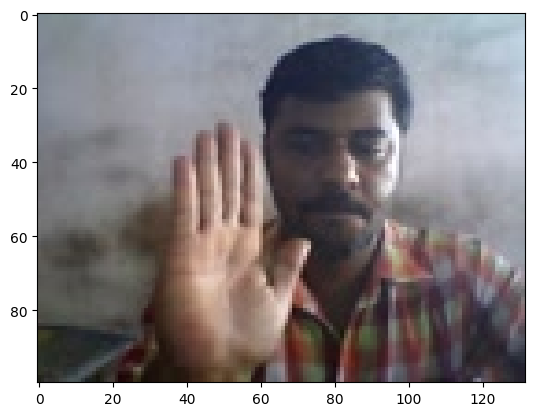

In [45]:
DATADIR2 = r'D:\TMS\dataset\jester\20bn-jester-v1\5454'

# OTTENGO I FRAME    
path = os.path.join(DATADIR2, '00003.jpg')  # create path (...\Color\rgb1)
frame = cv2.imread(path)  # convert to array
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))      

provo con modello *Holistic*

<class 'mediapipe.python.solution_base.SolutionOutputs'>


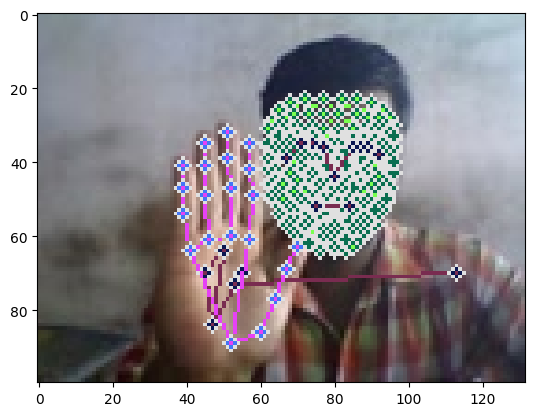

In [46]:
# ESTRAGGO I KEYPOINTS DA UN FRAME
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    image, results = mediapipe_detection(frame, holistic)
    draw_styled_landmarks(image, results)
    print(results)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  

    keypoints = extract_keypoints(results) #memorizzo i keypoints estratti    

In [47]:
keypoints.shape    

(1662,)

abbiamo 1662 keypoints per ogni frame

provo solamente con modello *Hands*

In [ ]:
# ESTRAGGO I KEYPOINTS DA CIASCUN FRAME
with mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5) as hands:
    image, results = mediapipe_detection(frame, hands)
    
    annotated_image = image.copy()
    
    for hand_landmarks in results.multi_hand_landmarks:        

        mp_drawing.draw_landmarks(     
            annotated_image,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=1),
            mp_drawing.DrawingSpec(color=(245,66,230), thickness=1, circle_radius=1)
            )

    print(results)
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))   

- ##### **qui** ⬇️ estraiamo i frame direttamente dai *video*

In [ ]:
myFrameNumber = 50
cap = cv2.VideoCapture("video.mp4")

# get total number of frames
totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

# check for valid frame number
if myFrameNumber >= 0 & myFrameNumber <= totalFrames:
    # set frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES,myFrameNumber)

while True:
    ret, frame = cap.read()
    cv2.imshow("Video", frame)
    if cv2.waitKey(20) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

- ##### **qui** ⬇️ estraiamo i frame direttamente dalla *videocamera*

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
                print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [16]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

creiamo un dizionario dove salviamo tutte le azioni/gesti:

In [17]:
label_map = {label:num for num, label in enumerate(gestures)} #iteriamo su ciascuna azione

In [ ]:
label_map

strutturiamo i dati fin ora raccolti, inserendoli in un unico array

In [ ]:
sorted(np.array(os.listdir(os.path.join(DATADIR))).astype(int))

In [18]:
#TEST
DATADIR = r'D:\TMS\dataset\jester\20bn-jester-v1' 
vid = 5454
frame_num = '00003'
int(frame_num)

res = np.load(os.path.join(DATADIR, str(vid), "keypoints", "{}.npy".format(frame_num)))
res #contiene, per un singolo frame, tutti i keypoints di ogni parte del corpo, concatenati in un unico array (faccia, posa, mani)

array([ 0.60706532,  0.44341007, -1.16697681, ...,  0.29720196,
        0.41752315, -0.03795106])

In [21]:
len(os.listdir(os.path.join(DATADIR, str(5269))))
len(actual_video) #lunghezza di tutti i video per cui abbiamo i keypoints, quindi diposniibli per la classificaizone

1661

abbiamo **1661** video al momento per cui sono stati estratti i keypoints per ogni frame, disponibili dunque per l'addestramento e il test del modello

In [22]:
videos, labels = [], [] # rispettivamente X (feature input) e Y (feature target)

for vid in actual_video: #np.array(os.listdir(os.path.join(DATADIR))).astype(int): #cast str to int
    
    window = [] #rappresenta un unico video: insieme di X frame

    num_frames = len(os.listdir(os.path.join(DATADIR, str(vid))))
    #print(num_frames)

    for frame_num in range(1, num_frames): #itero per tutti i frame estratti per quel video
        try:
            #faccio if perchè gli array dei keypoint sono salvati come '000xx.npy' e non come 'x.npy'-> #TODO rinominarli
            if frame_num < 10:
                res = np.load(os.path.join(DATADIR, str(vid), "keypoints", "0000{}.npy".format(frame_num)))
                window.append(res)
            else:
                res = np.load(os.path.join(DATADIR, str(vid), "keypoints", "000{}.npy".format(frame_num)))
                window.append(res)

        except: #N.B. potrebbe andare in errore perchè ci sono frame per cui non abbiamo estratto keypoints
            pass

    videos.append(window)
    #labels.append(label_map[action]) #TODO come associare la label a ogni video??
    # array monodimensionale (ci dice per ogni video quale azione è presente al suo interno: la prima, ... -> definizione di LABEL)

In [ ]:
np.save("videos", videos)

In [28]:
videos

[[array([ 0.46541679,  0.32155907, -1.08207655, ...,  0.81472546,
          0.65358049, -0.04572884]),
  array([ 0.46303397,  0.32168567, -1.05936861, ...,  0.80941516,
          0.65668797, -0.05767181]),
  array([ 0.46250632,  0.32292056, -1.06126773, ...,  0.82418782,
          0.65296018, -0.08247977]),
  array([ 0.46200866,  0.32380104, -1.07017827, ...,  0.81968278,
          0.65693027, -0.07594993]),
  array([ 0.46197879,  0.32387888, -1.07880414, ...,  0.8219496 ,
          0.65758145, -0.07489699]),
  array([ 0.46197593,  0.32453099, -1.11052978, ...,  0.83171976,
          0.65577555, -0.0788233 ]),
  array([ 0.46200705,  0.32511917, -1.10692978, ...,  0.83219838,
          0.65497327, -0.08144432]),
  array([ 0.46205312,  0.32593688, -1.07852316, ...,  0.83269358,
          0.65437889, -0.08032167]),
  array([ 0.4616622 ,  0.3273111 , -1.05480909, ...,  0.829467  ,
          0.639678  , -0.09164363]),
  array([ 0.46145239,  0.3280524 , -1.05882263, ...,  0.82950461,
       

In [27]:
window

[array([ 0.55413616,  0.47708929, -1.02544832, ...,  0.06454732,
         0.04360813, -0.04772742]),
 array([ 0.55466288,  0.48287478, -1.02544987, ...,  0.07995343,
         0.06166446, -0.07015271]),
 array([ 0.55872285,  0.48201251, -0.99286944, ...,  0.09323783,
         0.10038801, -0.07543501]),
 array([ 0.56183892,  0.48196515, -1.0688802 , ...,  0.13375849,
         0.17353645, -0.07389276]),
 array([ 0.56496704,  0.47608781, -1.06540632, ...,  0.15218759,
         0.2554369 , -0.10016081]),
 array([ 0.5679481 ,  0.48618975, -1.05830228, ...,  0.18515605,
         0.35414869, -0.11299922]),
 array([ 0.559874 ,  0.4882277, -0.9478789, ...,  0.       ,  0.       ,
         0.       ]),
 array([ 0.55487192,  0.4907788 , -0.8766405 , ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.55474907,  0.49817136, -0.88087153, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.55484098,  0.5012269 , -0.9089129 , ...,  0.        ,
         0.        ,  0.        

In [26]:
np.array(videos).shape

C:\Users\follo\AppData\Local\Temp\ipykernel_24152\431442950.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(videos).shape


(1661,)

In [40]:
np.array(labels).shape

(0,)

In [ ]:
X = np.array(videos)

In [ ]:
X.shape

trasformo feature categoriche in feature numeriche (One Hot Encoding)

In [ ]:
y = to_categorical(labels).astype(int)

splittiamo i dati in Training Sets e Test Sets

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05,stratify=y)

In [ ]:
y_test.shape

# 7. Build and Train LSTM Neural Network

Addestriamo la rete neurale (ricorrente) **LSTM**: 

- perchè usare MediaPipe Holistic + una rete neurale LSTM?
    - occorrono *meno dati*
    - più *veloce* nell'addestramento
    - riconoscimento più *veloce* <- RN più *semplice*

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard

**TensorBoard** ci offre una web app per monitorare il nostro modello: addestramento, accuratezza, ... 

In [ ]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
# il modello Sequential ci permette di aggiungere layer in mainera organizzata e facile
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662))) #64 unità
model.add(LSTM(128, return_sequences=True, activation='relu')) #return_sequences è neecessario per il passaggio di dati al layer successivo
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax')) #distribuzione di probabilità che assegna ad ogni azione una certa prob.

Compiliamo il modello, usando:

- loss function: "categorical cross entropy"
    - è obbligatoria per classificazione multi-classe

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=500, callbacks=[tb_callback])

In [ ]:
model.summary()

# 8. Make Predictions

In [ ]:
res = model.predict(X_test) #prendo tutte le predizioni dall'insieme di test
# res[0]: significa che prendo la prima prediction (quindi la prediction della prima azione presente in X_test)

poichè ad ogni azione è associata una probabilità, la mia predizione sarà quella che avrà probabilità **maggiore** fra esse

In [ ]:
actions[np.argmax(res[4])] #qual'è l'azione con il più altro valore di probabilità associato?

prendo la label della 4a azione: vedo quindi il *ground truth*

In [ ]:
actions[np.argmax(y_test[4])]

ovviamente, se le due azioni **coincidono** significa che il modello ha una **buona accuracy**

# 9. Save Weights

In [ ]:
model.save('action.h5')

In [ ]:
del model

In [ ]:
model.load_weights('action.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [ ]:
yhat = model.predict(X_test)

In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

In [ ]:
accuracy_score(ytrue, yhat)

# 11. Test in Real Time

In [ ]:
from scipy import stats

In [ ]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [ ]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()